In [74]:
import pandas as pd
import numpy as np
import os
import glob

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster


import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
pio.renderers.default = 'notebook' 
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

In [16]:
col_names = ['Fecha (GMT)',	'Altura Signif. del Oleaje(m)',	'Periodo Medio(s)', 'Periodo de Pico(s)', 'Direcc. Media de Proced.(0=N 90=E)',	'Mar de viento:  Altura signif. Espectral(m)',	'Mar de viento: Direcc. Media de Proced.(0=N 90=E)', 'Mar de fondo 1:  Altura signif. Espectral(m)', 'Mar de fondo 1:  Periodo Medio Espectral(s)',	'Mar de fondo 1: Direcc. Media de Proced.(0=N 90=E)', 'Mar de fondo 2:  Altura signif. Espectral(m)', 'Mar de fondo 2:  Periodo Medio Espectral(s)', 'Mar de fondo 2: Direcc. Media de Proced.(0=N 90=E)']
df_original = pd.read_csv('Data/spain/17255_27460_3077038_WAVE_20230615114433_20240622114433.csv', 
                 skiprows = 2, 
                 sep = '\t',
                 header = None,
                 names = col_names)

df_original['datetime'] = pd.to_datetime(df_original['Fecha (GMT)'].str.replace(r'\s+', ' ', regex=True), format='%Y %m %d %H')

df_original.head()

,Fecha (GMT),Altura Signif. del Oleaje(m),Periodo Medio(s),Periodo de Pico(s),Direcc. Media de Proced.(0=N 90=E),Mar de viento: Altura signif. Espectral(m),Mar de viento: Direcc. Media de Proced.(0=N 90=E),Mar de fondo 1: Altura signif. Espectral(m),Mar de fondo 1: Periodo Medio Espectral(s),Mar de fondo 1: Direcc. Media de Proced.(0=N 90=E),Mar de fondo 2: Altura signif. Espectral(m),Mar de fondo 2: Periodo Medio Espectral(s),Mar de fondo 2: Direcc. Media de Proced.(0=N 90=E),datetime
0,2023 06 15 00,0.58,4.85,5.65,350,0.0,180,0.45,4.17,16,0.28,7.37,322.0,2023-06-15 00:00:00
1,2023 06 15 01,0.57,4.85,7.52,347,0.0,180,0.43,4.11,16,0.27,7.29,323.0,2023-06-15 01:00:00
2,2023 06 15 02,0.56,4.85,7.52,345,0.0,180,0.41,4.04,16,0.21,9.87,293.0,2023-06-15 02:00:00
3,2023 06 15 03,0.55,4.85,10.01,343,0.0,180,0.40,3.98,15,0.40,16.85,293.0,2023-06-15 03:00:00
4,2023 06 15 04,0.55,4.86,10.01,340,0.0,180,0.39,3.92,15,0.39,15.49,293.0,2023-06-15 04:00:00


In [38]:
df = df_original[['datetime', 'Altura Signif. del Oleaje(m)', 'Periodo Medio(s)']].copy()
df.rename(columns = {'Altura Signif. del Oleaje(m)':'wave_height', 'Periodo Medio(s)':'period'}, inplace = True)
df.sort_values(by=['datetime'], inplace=True)
df.set_index(keys = 'datetime', inplace=True)
df = df.asfreq('60min')

print(df.shape)
df.head(10)

(8976, 2)


,wave_height,period
datetime,,
2023-06-15 00:00:00,0.58,4.85
2023-06-15 01:00:00,0.57,4.85
2023-06-15 02:00:00,0.56,4.85
2023-06-15 03:00:00,0.55,4.85
2023-06-15 04:00:00,0.55,4.86
2023-06-15 05:00:00,0.54,4.87
2023-06-15 06:00:00,0.54,4.89
2023-06-15 07:00:00,0.53,4.86
2023-06-15 08:00:00,0.54,4.48


[]

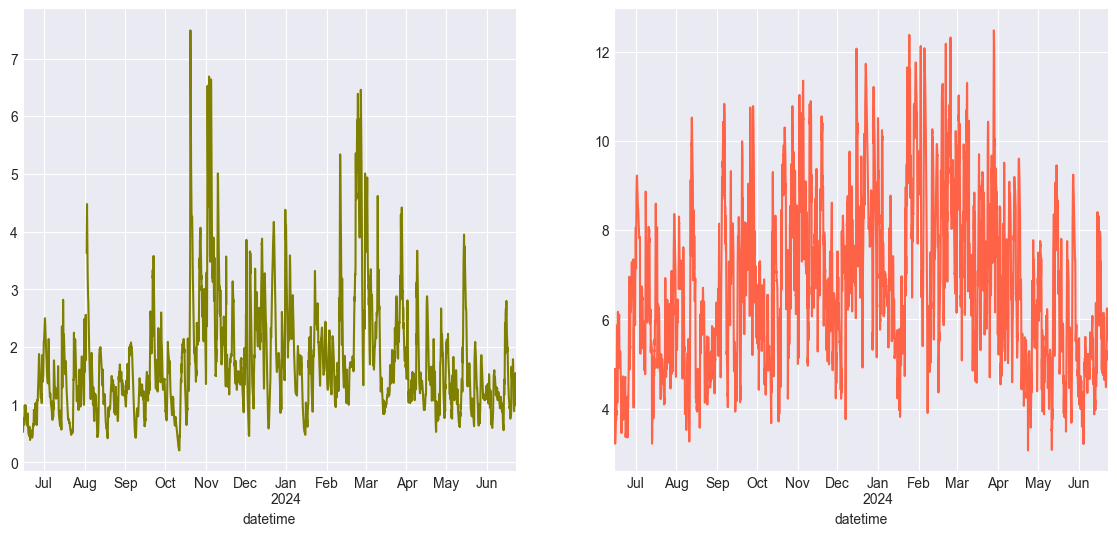

In [39]:
fig, ax = plt.subplots(1, 2, figsize = (14,6))

df['wave_height'].plot(ax=ax[0], color = 'olive')
df['period'].plot(ax=ax[1], color = 'tomato')

plt.plot()

In [41]:
df.isnull().value_counts()

wave_height  period
False        False     8952
True         True        24
Name: count, dtype: int64

In [40]:
df[df['wave_height'].isnull()]

,wave_height,period
datetime,,
2023-08-02 01:00:00,NaN,NaN
2023-08-02 02:00:00,NaN,NaN
2023-08-02 03:00:00,NaN,NaN
2023-08-02 04:00:00,NaN,NaN
2023-08-02 05:00:00,NaN,NaN
2023-08-02 06:00:00,NaN,NaN
2023-08-02 07:00:00,NaN,NaN
2023-08-02 08:00:00,NaN,NaN
2023-08-02 09:00:00,NaN,NaN


Since there aren't a lot of missing values, I am going to impute them with the equivalent value from the previous day. I don't think this will have a huge impact on the predictive ability of the model. 

In [43]:
# Impute missing values
# ==============================================================================
for col in df.columns:
    df[col] = df[col].fillna(df[col].shift(24))

df.isnull().value_counts()

wave_height  period
False        False     8976
Name: count, dtype: int64

In [44]:
# Train-test split
# ==============================================================================
one_month = (-1)*30*24 # One month
two_months = (-1)*60*24 # Two months

end_train = one_month + two_months
end_val = one_month

df_train = df.iloc[:end_train].copy()
df_val = df.iloc[end_train:end_val].copy()
df_test = df.iloc[end_val:].copy()

print(f"Train dates      : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Validation dates : {df_val.index.min()} --- {df_val.index.max()}  (n={len(df_val)})")
print(f"Test dates       : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

Train dates      : 2023-06-15 00:00:00 --- 2024-03-24 23:00:00  (n=6816)
Validation dates : 2024-03-25 00:00:00 --- 2024-05-23 23:00:00  (n=1440)
Test dates       : 2024-05-24 00:00:00 --- 2024-06-22 23:00:00  (n=720)


In [45]:
# Interactive plot of time series
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_train.index, y=df_train['wave_height'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=df_val.index, y=df_val['wave_height'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=df_test.index, y=df_test['wave_height'], mode='lines', name='Test'))
fig.update_layout(
    title  = '60-minute average wave height',
    xaxis_title="Time",
    yaxis_title="Meters",
    legend_title="Partition:",
    width=850,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
#fig.update_xaxes(rangeslider_visible=True)
fig.show()

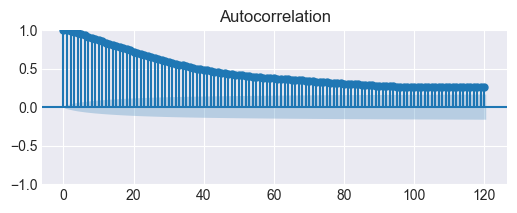

In [49]:
fig, ax = plt.subplots(figsize=(6, 2))
plot_acf(df['wave_height'], ax=ax, lags=120)
plt.show()

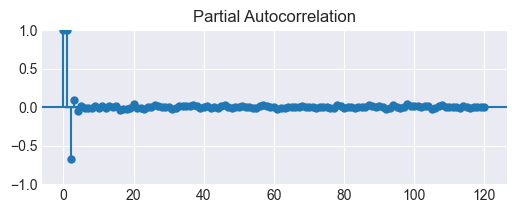

In [50]:
fig, ax = plt.subplots(figsize=(6, 2))
plot_pacf(df['wave_height'], ax=ax, lags=120)
plt.show()

## Baseline model

In [52]:
# Create baseline: value of the same hour of the previous day
# ==============================================================================
forecaster = ForecasterEquivalentDate(
                 offset    = pd.DateOffset(hours=1),
                 n_offsets = 1
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=df.iloc[:end_val]['wave_height'])
forecaster

ForecasterEquivalentDate 
Offset: <DateOffset: hours=1> 
Number of offsets: 1 
Aggregation function: mean 
Window size: 1 
Training range: [Timestamp('2023-06-15 00:00:00'), Timestamp('2024-05-23 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: 60min 
Creation date: 2024-06-24 11:52:49 
Last fit date: 2024-06-24 11:52:49 
Skforecast version: 0.12.1 
Python version: 3.11.9 
Forecaster id: None 

In [53]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df['wave_height'],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df.iloc[:end_val]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

print(f"Backtest error (MAE): {metric}")

100%|██████████| 30/30 [00:00<00:00, 127.27it/s]

Backtest error (MAE): 0.24463888888888888


## Recursive multi-step forecasting

A recursive autoregressive model `ForecasterAutoreg` is trained using a gradient boosting regressor `XGBRegressor` as the base regressor. A time window of 24 hours (24 lags) is used to predict the next hour's demand. This means that the demand values of the previous 24 hours are used as predictors. The hyperparameters of the underlying regressor are left at their default values.

We add a custom weight function to ignore missing values during training. 



In [69]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state = 42),
                lags = 24)

# Train forecaster
# ==============================================================================
forecaster.fit(y=df.iloc[:end_val]['wave_height'])
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous i

In [70]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df['wave_height'],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df.iloc[:end_val]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = True,
                          show_progress      = True
                      )

# Backtesting error
# ==============================================================================
print(f'Backtest error (MAE): {metric}')

Information of backtesting process
----------------------------------
Number of observations used for initial training: 8256
Number of observations used for backtesting: 720
    Number of folds: 30
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2023-06-15 00:00:00 -- 2024-05-23 23:00:00  (n=8256)
    Validation: 2024-05-24 00:00:00 -- 2024-05-24 23:00:00  (n=24)
Fold: 1
    Training:   2023-06-15 00:00:00 -- 2024-05-23 23:00:00  (n=8256)
    Validation: 2024-05-25 00:00:00 -- 2024-05-25 23:00:00  (n=24)
Fold: 2
    Training:   2023-06-15 00:00:00 -- 2024-05-23 23:00:00  (n=8256)
    Validation: 2024-05-26 00:00:00 -- 2024-05-26 23:00:00  (n=24)
Fold: 3
    Training:   2023-06-15 00:00:00 -- 2024-05-23 23:00:00  (n=8256)
    Validation: 2024-05-27 00:00:00 -- 2024-05-27 23:00:00  (n=24)
Fold: 4
    Training:   2023-06-15 00:00:00 -- 2024-05-23 23:00:00  (n=8256)
    Validation: 2024-05-28 00:00

100%|██████████| 30/30 [00:00<00:00, 95.75it/s]

Backtest error (MAE): 0.1960297660297818


In [71]:
# Plot predictions vs real value
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=df_test.index, y=df_test['wave_height'], name="actual", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Actual value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Wave height (meters)",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

### Hyperparameter tuning

The trained `ForecasterAutoreg` object used the first 24 lags and a `XGBRegressor` model with the default hyperparameters. However, there is no reason why these values are the most appropriate. To find the best hyperparameters, a Bayesian Search is performed using the `bayesian_search_forecaster()` function. The search is carried out using the same backtesting process as before, but each time, the model is trained with different combinations of hyperparameters and lags. It is important to note that the hiperparameter search must be done using the validation set, so the test data is never used.

In [79]:
# Hyperparameters search
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=42),
                 lags      = 24, # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [24, 48, [1, 2, 3, 24]]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 600, 1200, step=50),
        'max_depth'     : trial.suggest_int('max_depth', 3, 12, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
                                   forecaster         = forecaster,
                                   y                  = df.iloc[:end_val]['wave_height'],
                                   steps              = 24,
                                   metric             = 'mean_absolute_error',
                                   search_space       = search_space,
                                   lags_grid          = lags_grid,
                                   initial_train_size = len(df[:end_train]),
                                   refit              = False,
                                   n_trials           = 120, # Increase for more exhaustive search
                                   random_state       = 42,
                                   return_best        = True,
                                   n_jobs             = 'auto',
                                   verbose            = False,
                                   show_progress      = True
                               )

/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/model_selection/model_selection.py:1346: UserWarning:

The 'lags_grid' argument is deprecated and will be removed in a future version. Use the 'search_space' argument to define the candidate values for the lags. Example: {'lags' : trial.suggest_categorical('lags', [3, 5])}

Best trial: 92. Best value: 0.264842: 100%|██████████| 120/120 [07:46<00:00,  3.89s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'n_estimators': 900, 'max_depth': 4, 'learning_rate': 0.010968332232162158, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
  Backtesting metric: 0.2648422786047061



In [85]:
# Backtest final model on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df['wave_height'],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df[:end_val]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False, # Change to True to see detailed information
                          show_progress      = True
                      )

print(f"Backtest error: {metric:.2f}")

100%|██████████| 30/30 [00:00<00:00, 91.23it/s]

Backtest error: 0.20


No improvement over "dumb" XGBoost model

In [84]:
# Plot predictions vs real value
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=df_test.index, y=df_test['wave_height'], name="actual", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Actual value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Wave height (meters)",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()